In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# import warnings; warnings.simplefilter('ignore')
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import pandas as pd
from avian_vocalizations.data import preprocess, get_stats
from avian_vocalizations.data import AudioFeatureGenerator
from avian_vocalizations.model import CombinedModel #, MFCCModel, SgModel
# from avian_vocalizations.model import ModelFactory
from sklearn.preprocessing import LabelEncoder
import numpy as np
from matplotlib import pyplot as plt
from librosa.display import specshow
from avian_vocalizations.model import ModelFactory
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard #, Callback
from datetime import datetime

Using TensorFlow backend.


In [2]:
# st = get_stats()
# st.keys()

In [3]:
index_df = pd.read_csv('../data/xeno-canto_ca-nv_stats.csv', index_col='file_id')
label_encoder = LabelEncoder().fit(index_df['english_cname'] )
n_classes = len(label_encoder.classes_)
train_df = index_df.loc[pd.read_csv('../data/train_file_ids.csv')['file_id']]

y_train = label_encoder.fit_transform(train_df['english_cname'])

In [4]:
X_train = train_df.index.values
X_train

array([453098, 344803, 355425, ..., 326580, 144072, 450763], dtype=int64)

In [8]:
n_frames = 1024

In [9]:
generator = AudioFeatureGenerator(X_train, y_train, data_dir='../data',
            batch_size=3, shuffle=True, seed=37, n_frames=n_frames, scale=True)
Xs, ys = generator[0]
Xs.keys()

dict_keys(['melsg', 'mfcc', 'id', 'offset'])

In [6]:
ys

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

In [7]:
[label_encoder.classes_[np.argmax(y)] for y in ys]

['Western Wood Pewee', 'Common Poorwill', 'Hermit Thrush']

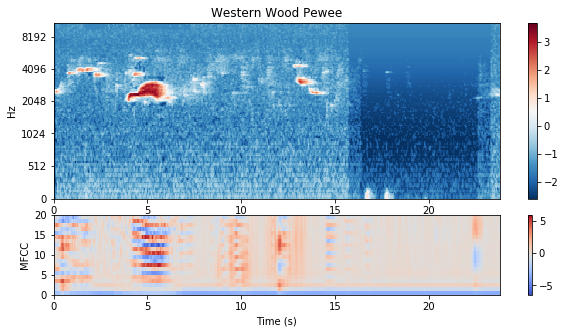

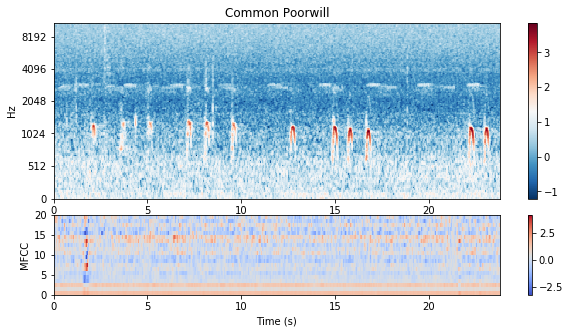

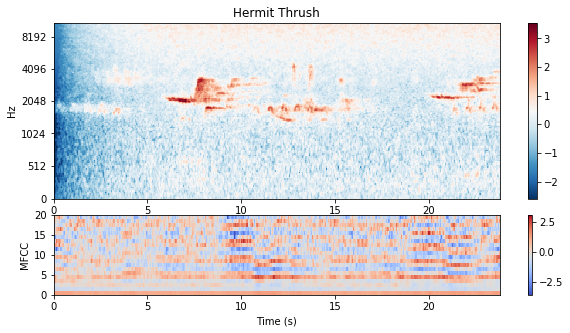

In [10]:
for i in range(3):
    gs = plt.GridSpec(3,1)
    fig = plt.figure(figsize=(10,5))
    msg_ax = fig.add_subplot(gs[:2])
    specshow(Xs['melsg'][i].reshape(Xs['melsg'][i].shape[:2]), 
             ax=msg_ax, x_axis='s', y_axis='mel', cmap='RdBu_r')
    plt.title(label_encoder.classes_[np.argmax(ys[i])])
    plt.colorbar(fig.gca().collections[0])
    mfcc_ax = fig.add_subplot(gs[2])
    specshow(Xs['mfcc'][i].reshape(Xs['mfcc'][i].shape[:2]),
             ax=mfcc_ax, x_axis='s')
    plt.yticks(range(0,21,5))
    plt.ylabel("MFCC")
    plt.colorbar(fig.gca().collections[0])
    plt.show()

In [11]:
Xs['mfcc'][0].shape, Xs['melsg'][0].shape

((20, 1024, 1), (128, 1024, 1))

In [18]:
model = CombinedModel(n_classes, n_frames=n_frames)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melsg (InputLayer)              (None, 128, 1024, 1) 0                                            
__________________________________________________________________________________________________
mfcc (InputLayer)               (None, 20, 1024, 1)  0                                            
__________________________________________________________________________________________________
sg_conv2d_1 (Conv2D)            (None, 126, 1022, 16 160         melsg[0][0]                      
__________________________________________________________________________________________________
mfcc_conv2d_1 (Conv2D)          (None, 20, 1022, 16) 64          mfcc[0][0]                       
____________________________________________________________________________________________

In [19]:
output_dir = 'training_example_output'
n_splits = 1
n_epochs = 50
batch_size = 24
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/4, random_state=37)
scores = []
for cv_train_index, cv_val_index in sss.split(X_train, y_train):
    training_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_train_index], 
        [y_train[i] for i in cv_train_index], 
        data_dir='../data', scale=True, batch_size=batch_size, n_classes=n_classes,
        shuffle=True, seed=37, n_frames=n_frames)
    validation_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_val_index], 
        [y_train[i] for i in cv_val_index], 
        data_dir='../data', scale=True, batch_size=batch_size, n_classes=n_classes,
        seed=37, n_frames=n_frames)
    
    partial_filename = "split%02i"%len(scores)
    checkpointer = ModelCheckpoint(verbose=1, save_best_only=True,
                   filepath=os.path.join(output_dir,'weights.best.%s.hdf5'%partial_filename))
    if not os.path.exists(output_dir): os.mkdir(output_dir)
    
    tensorboard_callback = TensorBoard("../tensorboard/CombinedModel_split%i_%s"%(
                             len(scores),
                             datetime.now().strftime("%Y_%m_%dT%H_%M_%S")))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    learning = model.fit_generator(
                training_generator, 
                validation_data=validation_generator,
                epochs=n_epochs, 
                steps_per_epoch=training_generator.n_batches,
                validation_steps=validation_generator.n_batches,
                callbacks=[checkpointer, tensorboard_callback], 
                #use_multiprocessing=True, workers=4,
                verbose=1, )
    history_output_file = os.path.join(output_dir,'training_history_split%i.csv'%len(scores))
    pd.DataFrame(learning.history).to_csv(history_output_file, index_label='epoch')
    acc_at_min_loss = learning.history['val_accuracy'][np.argmin(learning.history['val_loss'])]
    scores.append(acc_at_min_loss)
    print("Split %i: min loss: %.5f, accuracy at min loss: %.5f"%(
        len(scores), np.min(learning.history['val_loss']), acc_at_min_loss ))
print("Cross Validation Accuracy: mean(val_acc[argmin(val_loss)]): %.4f"%(np.mean(scores)))


Epoch 1/50
57/57 [==============================] - 22s 390ms/step - loss: 4.5171 - accuracy: 0.0095 - val_loss: 4.5081 - val_accuracy: 0.0264

Epoch 00001: val_loss improved from inf to 4.50807, saving model to training_example_output\weights.best.split00.hdf5
Epoch 2/50
57/57 [==============================] - 22s 380ms/step - loss: 4.4761 - accuracy: 0.0396 - val_loss: 4.3034 - val_accuracy: 0.0374

Epoch 00002: val_loss improved from 4.50807 to 4.30336, saving model to training_example_output\weights.best.split00.hdf5
Epoch 3/50
57/57 [==============================] - 22s 380ms/step - loss: 4.2615 - accuracy: 0.0542 - val_loss: 3.9164 - val_accuracy: 0.0527

Epoch 00003: val_loss improved from 4.30336 to 3.91642, saving model to training_example_output\weights.best.split00.hdf5
Epoch 4/50
57/57 [==============================] - 22s 380ms/step - loss: 4.0046 - accuracy: 0.0864 - val_loss: 3.8008 - val_accuracy: 0.0813

Epoch 00004: val_loss improved from 3.91642 to 3.80084, saving

57/57 [==============================] - 24s 419ms/step - loss: 0.3990 - accuracy: 0.8821 - val_loss: 8.2775 - val_accuracy: 0.2396

Epoch 00040: val_loss did not improve from 3.53886
Epoch 41/50
57/57 [==============================] - 23s 406ms/step - loss: 0.4894 - accuracy: 0.8454 - val_loss: 6.7653 - val_accuracy: 0.2308

Epoch 00041: val_loss did not improve from 3.53886
Epoch 42/50
57/57 [==============================] - 24s 413ms/step - loss: 0.4244 - accuracy: 0.8674 - val_loss: 8.2117 - val_accuracy: 0.2154

Epoch 00042: val_loss did not improve from 3.53886
Epoch 43/50
57/57 [==============================] - 23s 404ms/step - loss: 0.3656 - accuracy: 0.8901 - val_loss: 7.2151 - val_accuracy: 0.2066

Epoch 00043: val_loss did not improve from 3.53886
Epoch 44/50
57/57 [==============================] - 23s 404ms/step - loss: 0.3948 - accuracy: 0.8740 - val_loss: 8.4093 - val_accuracy: 0.2154

Epoch 00044: val_loss did not improve from 3.53886
Epoch 45/50
57/57 [=============